In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat
import pylab
from collections import Counter

## 1) Import the dataset

In [43]:
df = pd.read_csv("50_Startups.csv")
df.head()

# each row corresponds to a different startup

# Goal: Which startup to invest based on these information

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [44]:
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

### Check for missing values

In [45]:
df.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

### Check for outliers - Linear Regression is sensitive to outliers

In [46]:
plt.style.use("seaborn")

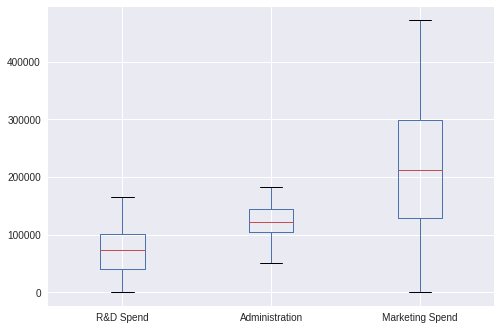

In [47]:
figure = df.boxplot(column=['R&D Spend', 'Administration', 'Marketing Spend'])

## 2) Create matrix of features and label

In [48]:
# X and y are numpy arrays

X = df.iloc[:,:-1].values # features
y = df.iloc[:,-1].values # label

## 3) Encoding the Categorical variables - One Hot Encoding

**Multiple Linear Regression Model takes care of dummy variable trap**

In [49]:
# convert categorical variables to dummy variables (0 or 1)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# [3] -> column index 3 
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
X = np.array(ct.fit_transform(X)) 

#  remainder='passthrough' --> columns, other than the ones specified, will remain untouched

In [50]:
X[:3] # check some rows

# 0 0 1 - new york
# 1 0 0 - california
# 0 1 0 - florida

# so, california, florida, new york --> dummy variables are created in alphabetical order

array([[0.0, 0.0, 1.0, 165349.2, 136897.8, 471784.1],
       [1.0, 0.0, 0.0, 162597.7, 151377.59, 443898.53],
       [0.0, 1.0, 0.0, 153441.51, 101145.55, 407934.54]], dtype=object)

**Note:** In multiple linear regression, there is no need to apply feature scaling

## 4) Splitting the dataset into the Training set and Test set

In [51]:
from sklearn.model_selection import train_test_split

# Train - 80% data, Test - 20% data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [52]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape # all matrices

((40, 6), (40,), (10, 6), (10,))

## 5) Training the Model on the train set

**Multiple Linear Regression Model will identify the best features (highest p-value)**


In [53]:
from sklearn.linear_model import LinearRegression
model = LinearRegression() # Build model

model.fit(X_train,y_train) # Train model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 6) Evaluate Model - Predicting on Test results

We cannot plot a graph because we have a lot of features.
SO instead of visualization, we will display 2 vectors .....

true profits from test set, and predicted profits from test set, so that we can compare if predicted is close to real

In [54]:
# Test set --> evaluate model on new observations (future data)

# Input the features to predict the label(estimated), returns a vector(matrix)
y_pred = model.predict(X_test) 

In [55]:
np.set_printoptions(precision=2) # 2 dp numerical values

# Concatenate the 2 vectors (Compare two numerical vectors - estimated and true)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)), axis=1))

# reshape vector from horizantal to vertical
# axis = 1 for vertical concatenation

# first column --> predicted profit, second column --> true profit

[[114664.42 105008.31]
 [ 90593.16  96479.51]
 [ 75692.84  78239.91]
 [ 70221.89  81229.06]
 [179790.26 191050.39]
 [171576.92 182901.99]
 [ 49753.59  35673.41]
 [102276.66 101004.64]
 [ 58649.38  49490.75]
 [ 98272.03  97483.56]]


In [56]:
def evaluate_preds(y_test, y_pred):
  """
  Perform evaluation comparison methods on y_test(true labels) vs y_pred -- for regression problems
  """
  from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

  accuracy = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred) # Gradient Descent
  mae = mean_absolute_error(y_test, y_pred)
  metric_dict = {
      "r2": round(accuracy,2),
      "mse": round(mse,2),
      "mae": round(mae,2)
  }

  print("Regression model metrics on the test set:")
  print(f"Co-efficient of R^2: {accuracy * 100:.2f}%") # accuracy of model
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Mean absolute Error: {mae:.2f}")

  return metric_dict

In [57]:
evaluation_metrics = evaluate_preds(y_test, y_pred)

Regression model metrics on the test set:
Co-efficient of R^2: 96.50%
Mean Squared Error: 79495441.50
Mean absolute Error: 7698.12


## 7) Predicting Values


#### Q1) Making a single prediction (for example the profit of a startup with R&D Spend = 160000, Administration Spend = 130000, Marketing Spend = 300000 and State = 'California')

**Important note 1:** Notice that the values of the features were all input in a double pair of square brackets. That's because the "predict" method always expects a 2D array as the format of its inputs. And putting our values into a double pair of square brackets makes the input exactly a 2D array. Simply put:

1,0,0,160000,130000,300000→scalars

[1,0,0,160000,130000,300000]→1D array

[[1,0,0,160000,130000,300000]]→2D array

**Important note 2**: Notice also that the "California" state was not input as a string in the last column but as "1, 0, 0" in the first three columns. That's because the predict method expects the one-hot-encoded values of the state, "California" was encoded as "1, 0, 0". And be careful to include these values in the first three columns, not the last three ones, because the dummy variables are always created in the first columns.

In [59]:
print(model.predict([[1, 0, 0, 160000, 130000, 300000]]))

[180892.25]


Therefore, our model predicts that the profit of a Californian startup which spent 160000 in R&D, 130000 in Administration and 300000 in Marketing is $180892.25

#### Q2) Getting the final linear regression equation with the values of the coefficients

In [61]:
# h(x) = theta0 + theta1X1 + theta2X2 + theta3X3 +....
print(model.coef_) 
print(model.intercept_) # y intercept - theta0

[-2.85e+02  2.98e+02 -1.24e+01  7.74e-01 -9.44e-03  2.89e-02]
49834.885073228004


Therefore, the equation of our multiple linear regression model/hypothesis equation is:

Profit = - 285×Dummy State 1 − 298×Dummy State 2 - 124×Dummy State 3 + 774×R&D Spend - 944×Administration + 289×Marketing Spend + 49834.88507321703

## 8) Save the Model

In [62]:
from joblib import dump

# Save a model to a file
dump(model,filename='multivariate_linear_regression.pkl')

['multivariate_linear_regression.pkl']